# Reconocimiento Facial VGGFACE2

In [52]:
import os

# Nombre de la carpeta donde quieres guardar la imagen
folder_name = 'images'

# Comprueba si la carpeta existe, y si no, créala
if not os.path.exists(folder_name):
    os.makedirs(folder_name)


In [53]:
from urllib.request import urlretrieve

# Imagen con una sola cara
url = ('https://github.com/giangrobert/reconigtion_facial/' + 'raw/master/images/salon.png')
urlretrieve(url=url, filename='images/imagen_1.png')

# Imagen con una sola cara
url = ('https://github.com/giangrobert/reconigtion_facial/' + 'raw/master/images/gian.png')
urlretrieve(url=url, filename='images/imagen_2.png')

('images/imagen_2.png', <http.client.HTTPMessage at 0x7bc5a076d000>)

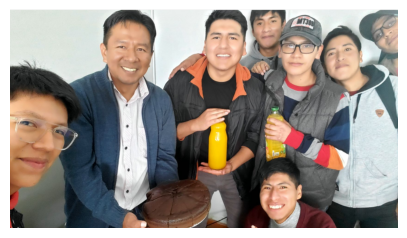

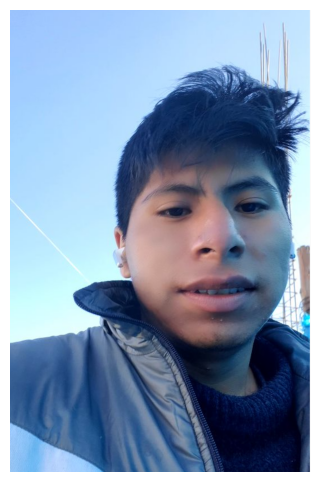

In [54]:
# Lectura de imágenes
# ==============================================================================
from PIL import Image
import cv2
import matplotlib.pyplot as plt

imagen_1 = Image.open('images/imagen_1.png')
imagen_2 = Image.open('images/imagen_2.png')
# imagen_1 = cv2.imread('images/imagen_1.jpg')
# imagen_2 = cv2.imread('images/imagen_2.png')

# Representación de imágenes
# ==============================================================================
plt.figure(figsize=(5, 4))
plt.imshow(imagen_1)
plt.axis('off');

plt.figure(figsize=(10, 6))
plt.imshow(imagen_2)
plt.axis('off');

In [55]:
!pip install facenet-pytorch

In [56]:
import torch
from facenet_pytorch import MTCNN
import numpy as np

# Detectar si se dispone de GPU cuda
# ==============================================================================
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(device))

# Detector MTCNN
# ==============================================================================
mtcnn = MTCNN(
            select_largest = True,
            min_face_size  = 20,
            thresholds     = [0.6, 0.7, 0.7],
            post_process   = False,
            image_size     = 160,
            device = device
)

Running on device: cuda:0


In [57]:
# Detección de bounding box y landmarks

if imagen_2.mode == 'RGBA':
    imagen_2 = imagen_2.convert('RGB')

# ==============================================================================
boxes, probs, landmarks = mtcnn.detect(imagen_2, landmarks=True)
print('Bounding boxes:', boxes)
print('Probability:', probs)
print('landmarks:', landmarks)

Bounding boxes: [[205.60292053222656 223.0869598388672 489.6413879394531 590.43994140625]]
Probability: [0.9998816251754761]
landmarks: [[[294.34259033203125 351.8593444824219]
  [426.2903137207031 345.856201171875]
  [369.95770263671875 415.6385803222656]
  [305.1578063964844 499.8379211425781]
  [423.2943115234375 493.9676513671875]]]


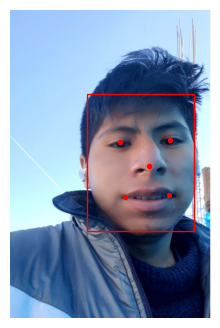

In [58]:
# Representación con matplotlib
# ==============================================================================
# En punto de origen (0,0) de una imagen es la esquina superior izquierda
box = boxes[0]
landmark = landmarks[0]
fig, ax  = plt.subplots(figsize=(5, 4))
ax.imshow(imagen_2)
ax.scatter(landmark[:, 0], landmark[:, 1], s=8, c= 'red')
rect = plt.Rectangle(
            xy     = (box[0], box[1]),
            width  = box[2] - box[0],
            height = box[3] - box[1],
            fill   = False,
            color  = 'red'
       )
ax.add_patch(rect)
ax.axis('off');

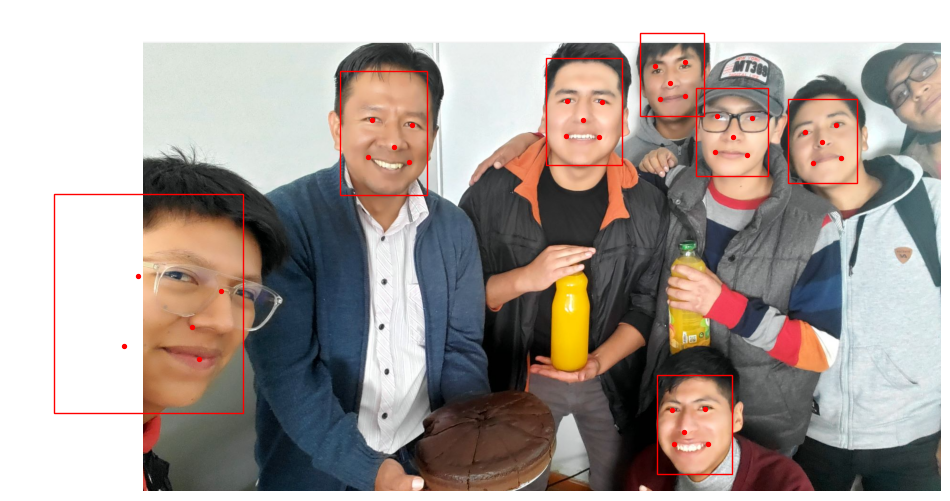

In [60]:
# Detección de bounding box y landmarks
# ==============================================================================
if imagen_1.mode == 'RGBA':
    imagen_1 = imagen_1.convert('RGB')

boxes, probs, landmarks = mtcnn.detect(imagen_1, landmarks=True)

# Representación con matplotlib
# ==============================================================================
fig, ax = plt.subplots(figsize=(12, 7))
ax.imshow(imagen_1)

for box, landmark in zip(boxes, landmarks):
    ax.scatter(landmark[:, 0], landmark[:, 1], s=8, c= 'red')
    rect = plt.Rectangle(
                xy     = (box[0], box[1]),
                width  = box[2] - box[0],
                height = box[3] - box[1],
                fill   = False,
                color  = 'red'
           )
    ax.add_patch(rect)

ax.axis('off');

In [61]:
# Detección de cara
# ==============================================================================
face = mtcnn.forward(imagen_2)

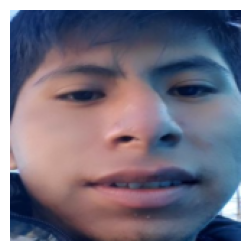

In [62]:
# Representación con matplotlib
# ==============================================================================
fig, ax = plt.subplots(1, 1, figsize=(3, 3))
face = face.permute(1, 2, 0).int().numpy()
ax.imshow(face)
plt.axis('off');

In [64]:
# Detector MTCNN
# ==============================================================================
mtcnn = MTCNN(
            keep_all      = True,
            min_face_size = 20,
            thresholds    = [0.6, 0.7, 0.7],
            post_process  = False,
            image_size    = 160,
            device        = device
        )

# Detección de caras
# ==============================================================================
faces = mtcnn.forward(imagen_1)

In [65]:
faces.shape

torch.Size([7, 3, 160, 160])

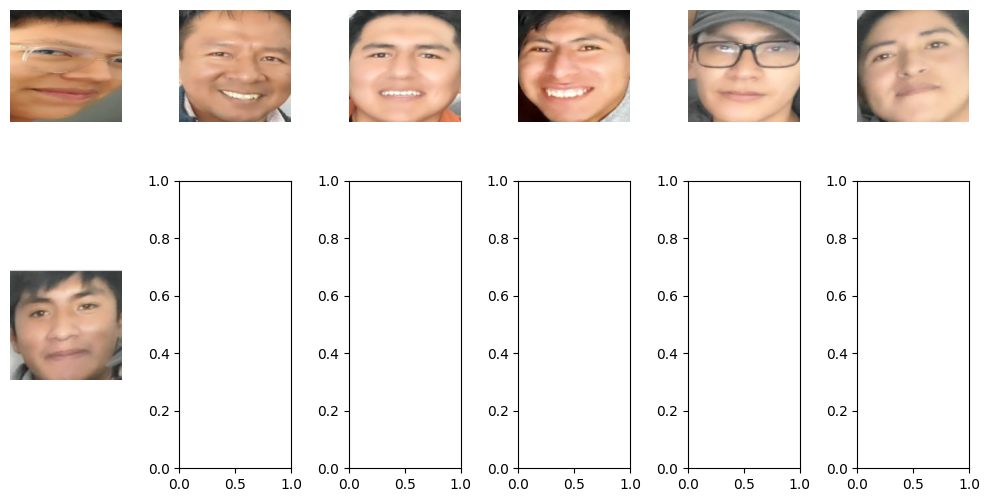

In [66]:
# ==============================================================================
fig, axs = plt.subplots(nrows=2, ncols=6, figsize=(10, 6))
axs= axs.flatten()

for i in range(faces.shape[0]):
    face = faces[i,:,:,:].permute(1, 2, 0).int().numpy()
    axs[i].imshow(face)
    axs[i].axis('off')

plt.tight_layout();

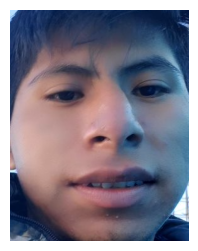

In [67]:
# Extracción de cara a partir de una bounding box
# ==============================================================================
boxes, probs, landmarks = mtcnn.detect(imagen_2, landmarks=True)
x1, y1, x2, y2 = boxes[0].astype(int)
recorte_cara = np.array(imagen_2)[y1:y2, x1:x2]

fig, ax = plt.subplots(1, 1, figsize=(3, 3))
plt.imshow(recorte_cara)
plt.axis('off');

In [68]:
# Modelo para hacer el embedding de las caras
# ==============================================================================
from facenet_pytorch import InceptionResnetV1
encoder = InceptionResnetV1(pretrained='vggface2', classify=False, device=device).eval()

In [69]:
# Detección de cara
# ==============================================================================
cara = mtcnn(imagen_2)

In [70]:
# Embedding de cara
import torch

# Verifica si hay una GPU disponible
if torch.cuda.is_available():
    # Mueve la imagen a la GPU
    cara = cara.to('cuda')

# ==============================================================================
embedding_cara = encoder.forward(cara.reshape((1,3, 160, 160))).detach().cpu()
embedding_cara

tensor([[ 4.1724e-02, -8.5559e-03,  3.0952e-02,  2.2569e-02,  7.5252e-02,
         -6.8315e-02, -8.8573e-03,  4.1612e-03, -2.6838e-02, -3.7879e-02,
         -7.9520e-02, -4.7202e-02, -9.5527e-02, -3.1825e-02,  6.6137e-02,
         -3.5859e-02, -4.8555e-03, -1.3693e-02,  2.2673e-02,  4.3025e-02,
          2.3188e-02,  4.5405e-02, -7.0731e-02, -9.3376e-03,  1.5203e-02,
         -3.6650e-03,  1.1885e-01, -2.7732e-03,  3.8766e-02, -8.5644e-02,
         -3.0632e-02,  2.5572e-02,  2.0867e-02,  2.3022e-02,  5.9473e-02,
          1.4103e-02, -6.7544e-02,  3.3446e-02, -8.3425e-03,  2.1520e-02,
         -1.3690e-02,  3.4049e-02,  3.0012e-02, -1.3125e-01, -1.8764e-02,
         -3.5401e-02,  1.2667e-02, -3.6307e-02, -3.3343e-02,  4.1571e-02,
          1.0900e-01,  6.7795e-02,  6.3019e-02,  5.5104e-02, -1.7242e-02,
         -6.2749e-02,  3.7231e-02,  7.0902e-02, -1.1607e-02,  9.7269e-03,
         -9.8913e-03, -9.6269e-02,  7.8038e-02, -3.6428e-02, -1.6310e-04,
          1.5402e-02,  2.7584e-02,  1.

In [71]:
# Detector MTCNN
# ==============================================================================
mtcnn = MTCNN(
            keep_all      = True,
            min_face_size = 20,
            thresholds    = [0.6, 0.7, 0.7],
            post_process  = False,
            image_size    = 160,
            device        = device
        )

In [72]:
# Extracción de las caras MTCNN
# ==============================================================================
phil_1 = mtcnn(imagen_2)[0]
phil_2 = mtcnn(imagen_1)[2]

(-0.5, 159.5, 159.5, -0.5)

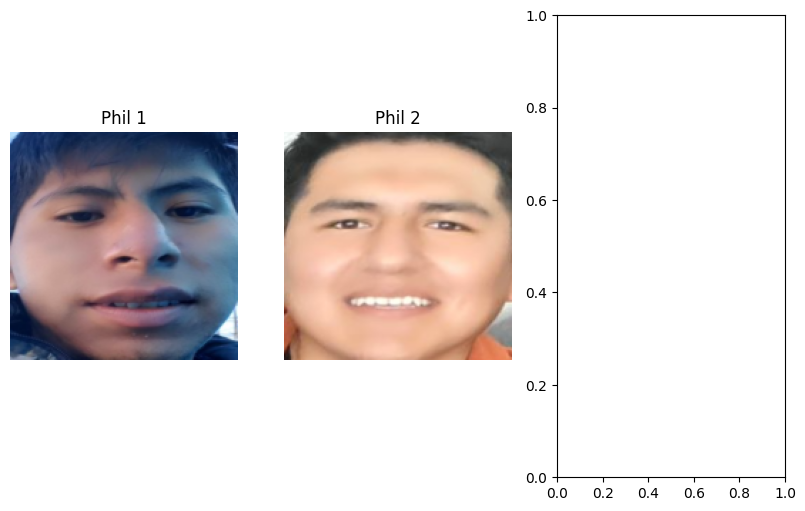

In [73]:
# Representación con matplotlib
# ==============================================================================
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(10, 6))

face = phil_1.permute(1, 2, 0).int().numpy()
axs[0].imshow(face)
axs[0].set_title('Phil 1')
axs[0].axis('off')

face = phil_2.permute(1, 2, 0).int().numpy()
axs[1].imshow(face)
axs[1].set_title('Phil 2')
axs[1].axis('off')

In [82]:
!pip install facenet-pytorch

In [107]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
import warnings
import typing
import logging
import os
import platform
import glob
import PIL
import facenet_pytorch
from typing import Union, Dict
from PIL import Image
from facenet_pytorch import MTCNN
from facenet_pytorch import InceptionResnetV1
from urllib.request import urlretrieve
from tqdm import tqdm
from scipy.spatial.distance import euclidean
from scipy.spatial.distance import cosine

warnings.filterwarnings('ignore')

logging.basicConfig(
    format = '%(asctime)-5s %(name)-10s %(levelname)-5s %(message)s',
    level  = logging.WARNING,
)


# Funciones para la detección, extracción, embedding, identificación y gráficos
# ==============================================================================
def detectar_caras(imagen: Union[PIL.Image.Image, np.ndarray],
                   detector: facenet_pytorch.models.mtcnn.MTCNN=None,
                   keep_all: bool        = True,
                   min_face_size: int    = 20,
                   thresholds: list      = [0.6, 0.7, 0.7],
                   device: str           = None,
                   min_confidence: float = 0.5,
                   fix_bbox: bool        = True,
                   verbose               = False)-> np.ndarray:

    # Comprobaciones iniciales
    # --------------------------------------------------------------------------
    if not isinstance(imagen, (np.ndarray, PIL.Image.Image)):
        raise Exception(
            f"`imagen` debe ser `np.ndarray, PIL.Image`. Recibido {type(imagen)}."
        )

    if detector is None:
        logging.info('Iniciando detector MTCC')
        detector = MTCNN(
                        keep_all      = keep_all,
                        min_face_size = min_face_size,
                        thresholds    = thresholds,
                        post_process  = False,
                        device        = device
                   )

    # Detección de caras
    # --------------------------------------------------------------------------
    if isinstance(imagen, PIL.Image.Image):
        imagen = np.array(imagen).astype(np.float32)

    bboxes, probs = detector.detect(imagen, landmarks=False)

    if bboxes is None:
        bboxes = np.array([])
        probs  = np.array([])
    else:
        # Se descartan caras con una probabilidad estimada inferior a `min_confidence`.
        bboxes = bboxes[probs > min_confidence]
        probs  = probs[probs > min_confidence]

    logging.info(f'Número total de caras detectadas: {len(bboxes)}')
    logging.info(f'Número final de caras seleccionadas: {len(bboxes)}')

    # Corregir bounding boxes
    #---------------------------------------------------------------------------
    # Si alguna de las esquinas de la bounding box está fuera de la imagen, se
    # corrigen para que no sobrepase los márgenes.
    if len(bboxes) > 0 and fix_bbox:
        for i, bbox in enumerate(bboxes):
            if bbox[0] < 0:
                bboxes[i][0] = 0
            if bbox[1] < 0:
                bboxes[i][1] = 0
            if bbox[2] > imagen.shape[1]:
                bboxes[i][2] = imagen.shape[1]
            if bbox[3] > imagen.shape[0]:
                bboxes[i][3] = imagen.shape[0]

    # Información de proceso
    # ----------------------------------------------------------------------
    if verbose:
        print("----------------")
        print("Imagen escaneada")
        print("----------------")
        print(f"Caras detectadas: {len(bboxes)}")
        print(f"Correción bounding boxes: {ix_bbox}")
        print(f"Coordenadas bounding boxes: {bboxes}")
        print(f"Confianza bounding boxes:{probs} ")
        print("")

    return bboxes.astype(int)


def mostrar_bboxes(imagen: Union[PIL.Image.Image, np.ndarray],
                   bboxes: np.ndarray,
                   identidades: list=None,
                   ax=None ) -> None:
    # Comprobaciones iniciales
    # --------------------------------------------------------------------------
    if not isinstance(imagen, (np.ndarray, PIL.Image.Image)):
        raise Exception(
            f"`imagen` debe ser `np.ndarray, PIL.Image`. Recibido {type(imagen)}."
        )

    if identidades is not None:
        if len(bboxes) != len(identidades):
            raise Exception(
                '`identidades` debe tener el mismo número de elementos que `bboxes`.'
            )
    else:
        identidades = [None] * len(bboxes)

    # Mostrar la imagen y superponer bounding boxes
    # --------------------------------------------------------------------------
    if ax is None:
        ax = plt.gca()

    if isinstance(imagen, PIL.Image.Image):
        imagen = np.array(imagen).astype(np.float32) / 255

    ax.imshow(imagen)
    ax.axis('off')

    if len(bboxes) > 0:

        for i, bbox in enumerate(bboxes):
            if identidades[i] is not None:
                rect = plt.Rectangle(
                            xy        = (bbox[0], bbox[1]),
                            width     = bbox[2] - bbox[0],
                            height    = bbox[3] - bbox[1],
                            linewidth = 1,
                            edgecolor = 'lime',
                            facecolor = 'none'
                        )

                ax.add_patch(rect)

                ax.text(
                    x = bbox[0],
                    y = bbox[1] -10,
                    s = identidades[i],
                    fontsize = 10,
                    color    = 'lime'
                )
            else:
                rect = plt.Rectangle(
                            xy        = (bbox[0], bbox[1]),
                            width     = bbox[2] - bbox[0],
                            height    = bbox[3] - bbox[1],
                            linewidth = 1,
                            edgecolor = 'red',
                            facecolor = 'none'
                        )

                ax.add_patch(rect)

        plt.show()


def mostrar_bboxes_cv2(imagen: Union[PIL.Image.Image, np.ndarray],
                       bboxes: np.ndarray,
                       identidades: list=None,
                       device: str='window') -> None:

    # Comprobaciones iniciales
    # --------------------------------------------------------------------------
    if not isinstance(imagen, (np.ndarray, PIL.Image.Image)):
        raise Exception(
            f"`imagen` debe ser `np.ndarray`, `PIL.Image`. Recibido {type(imagen)}."
        )

    if identidades is not None:
        if len(bboxes) != len(identidades):
            raise Exception(
                '`identidades` debe tener el mismo número de elementos que `bboxes`.'
            )
    else:
        identidades = [None] * len(bboxes)

    # Mostrar la imagen y superponer bounding boxes
    # --------------------------------------------------------------------------
    if isinstance(imagen, PIL.Image.Image):
        imagen = np.array(imagen).astype(np.float32) / 255

    if len(bboxes) > 0:

        for i, bbox in enumerate(bboxes):

            if identidades[i] is not None:
                cv2.rectangle(
                    img       = imagen,
                    pt1       = (bbox[0], bbox[1]),
                    pt2       = (bbox[2], bbox[3]),
                    color     = (0, 255, 0),
                    thickness = 2
                )

                cv2.putText(
                    img       = imagen,
                    text      = identidades[i],
                    org       = (bbox[0], bbox[1]-10),
                    fontFace  = cv2.FONT_HERSHEY_SIMPLEX,
                    fontScale = 1e-3 * imagen.shape[0],
                    color     = (0,255,0),
                    thickness = 2
                )
            else:
                cv2.rectangle(
                    img       = imagen,
                    pt1       = (bbox[0], bbox[1]),
                    pt2       = (bbox[2], bbox[3]),
                    color     = (255, 0, 0),
                    thickness = 2
                )

    if device is None:
        return imagen
    else:
        cv2.imshow(device, cv2.cvtColor(imagen, cv2.COLOR_BGR2RGB))
        if cv2.waitKey(1) == 27:
            brcv2.destroyAllWindows()  # esc para cerrar la ventana


def extraer_caras(imagen: Union[PIL.Image.Image, np.ndarray],
                  bboxes: np.ndarray,
                  output_img_size: Union[list, tuple, np.ndarray]=[160, 160]) -> None:

    # Comprobaciones iniciales
    # --------------------------------------------------------------------------
    if not isinstance(imagen, (np.ndarray, PIL.Image.Image)):
        raise Exception(
            f"`imagen` debe ser np.ndarray, PIL.Image. Recibido {type(imagen)}."
        )

    # Recorte de cara
    # --------------------------------------------------------------------------
    if isinstance(imagen, PIL.Image.Image):
        imagen = np.array(imagen)

    if len(bboxes) > 0:
        caras = []
        for bbox in bboxes:
            x1, y1, x2, y2 = bbox
            cara = imagen[y1:y2, x1:x2]
            # Redimensionamiento del recorte
            cara = Image.fromarray(cara)
            cara = cara.resize(tuple(output_img_size))
            cara = np.array(cara)
            caras.append(cara)

    caras = np.stack(caras, axis=0)

    return caras


def calcular_embeddings(img_caras: np.ndarray, encoder=None,
                        device: str=None) -> np.ndarray:

    # Comprobaciones iniciales
    # --------------------------------------------------------------------------
    if not isinstance(img_caras, np.ndarray):
        raise Exception(
            f"`img_caras` debe ser np.ndarray {type(img_caras)}."
        )

    if img_caras.ndim != 4:
        raise Exception(
            f"`img_caras` debe ser np.ndarray con dimensiones [nº caras, ancho, alto, 3]."
            f" Recibido {img_caras.ndim}."
        )

    if encoder is None:
        logging.info('Iniciando encoder InceptionResnetV1')
        encoder = InceptionResnetV1(
                        pretrained = 'vggface2',
                        classify   = False,
                        device     = device
                   ).eval()

    caras = np.moveaxis(img_caras, -1, 1)
    caras = caras.astype(np.float32) / 255
    caras = torch.tensor(caras)
    embeddings = encoder.forward(caras).detach().cpu().numpy()

    return embeddings


def identificar_caras(embeddings: np.ndarray,
                      dic_referencia: dict,
                      threshold_similaridad: float = 0.6) -> list:
    identidades = []

    for i in range(embeddings.shape[0]):
        # Se calcula la similitud con cada uno de los perfiles de referencia.
        similitudes = {}
        for key, value in dic_referencia.items():
            # Asegurarse de que los embeddings sean 1-D
            if len(embeddings[i].shape) > 1:
                embeddings[i] = embeddings[i].flatten()
            if len(value.shape) > 1:
                value = value.flatten()

            similitudes[key] = 1 - cosine(embeddings[i], value)

        identidad = max(similitudes, key=similitudes.get)
        if similitudes[identidad] < threshold_similaridad:
            identidad = None

        identidades.append(identidad)

    return identidades


def crear_diccionario_referencias(folder_path:str,
                                  dic_referencia:dict=None,
                                  detector: facenet_pytorch.models.mtcnn.MTCNN=None,
                                  min_face_size: int=40,
                                  thresholds: list=[0.6, 0.7, 0.7],
                                  min_confidence: float=0.9,
                                  encoder=None,
                                  device: str=None,
                                  verbose: bool=False)-> dict:

    # Comprobaciones iniciales
    # --------------------------------------------------------------------------
    if not os.path.isdir(folder_path):
        raise Exception(
            f"Directorio {folder_path} no existe."
        )

    if len(os.listdir(folder_path) ) == 0:
        raise Exception(
            f"Directorio {folder_path} está vacío."
        )


    if detector is None:
        logging.info('Iniciando detector MTCC')
        detector = MTCNN(
                        keep_all      = False,
                        post_process  = False,
                        min_face_size = min_face_size,
                        thresholds    = thresholds,
                        device        = device
                   )

    if encoder is None:
        logging.info('Iniciando encoder InceptionResnetV1')
        encoder = InceptionResnetV1(
                        pretrained = 'vggface2',
                        classify   = False,
                        device     = device
                   ).eval()


    new_dic_referencia = {}
    folders = glob.glob(folder_path + "/*")

    for folder in folders:

        if platform.system() in ['Linux', 'Darwin']:
            identidad = folder.split("/")[-1]
        else:
            identidad = folder.split("\\")[-1]

        logging.info(f'Obteniendo embeddings de: {identidad}')
        embeddings = []
        # Se lista todas las imagenes .jpg .jpeg .tif .png
        path_imagenes = glob.glob(folder + "/*.jpg")
        path_imagenes.extend(glob.glob(folder + "/*.jpeg"))
        path_imagenes.extend(glob.glob(folder + "/*.tif"))
        path_imagenes.extend(glob.glob(folder + "/*.png"))
        logging.info(f'Total imagenes referencia: {len(path_imagenes)}')

        for path_imagen in path_imagenes:
            logging.info(f'Leyendo imagen: {path_imagen}')
            imagen = Image.open(path_imagen)
            # Si la imagen es RGBA se pasa a RGB
            if np.array(imagen).shape[2] == 4:
                imagen  = np.array(imagen)[:, :, :3]
                imagen  = Image.fromarray(imagen)

            bbox = detectar_caras(
                        imagen,
                        detector       = detector,
                        min_confidence = min_confidence,
                        verbose        = False
                    )

            if len(bbox) > 1:
                logging.warning(
                    f'Más de 2 caras detectadas en la imagen: {path_imagen}. '
                    f'Se descarta la imagen del diccionario de referencia.'
                )
                continue

            if len(bbox) == 0:
                logging.warning(
                    f'No se han detectado caras en la imagen: {path_imagen}.'
                )
                continue

            cara = extraer_caras(imagen, bbox)
            embedding = calcular_embeddings(cara, encoder=encoder)
            embeddings.append(embedding)

        if verbose:
            print(f"Identidad: {identidad} --- Imágenes referencia: {len(embeddings)}")

        embedding_promedio = np.array(embeddings).mean(axis=0).flatten()
        new_dic_referencia[identidad] = embedding_promedio

    if dic_referencia is not None:
        dic_referencia.update(new_dic_referencia)
        return dic_referencia
    else:
        return new_dic_referencia

In [86]:
def pipeline_deteccion_imagen(imagen: Union[PIL.Image.Image, np.ndarray],
                              dic_referencia:dict,
                              detector: facenet_pytorch.models.mtcnn.MTCNN=None,
                              keep_all: bool=True,
                              min_face_size: int=20,
                              thresholds: list=[0.6, 0.7, 0.7],
                              device: str=None,
                              min_confidence: float=0.5,
                              fix_bbox: bool=True,
                              output_img_size: Union[list, tuple, np.ndarray]=[160, 160],
                              encoder=None,
                              threshold_similaridad: float=0.5,
                              ax=None,
                              verbose=False)-> None:
    bboxes = detectar_caras(
                imagen         = imagen,
                detector       = detector,
                keep_all       = keep_all,
                min_face_size  = min_face_size,
                thresholds     = thresholds,
                device         = device,
                min_confidence = min_confidence,
                fix_bbox       = fix_bbox
              )

    if len(bboxes) == 0:

        logging.info('No se han detectado caras en la imagen.')
        mostrar_bboxes(
            imagen      = imagen,
            bboxes      = bboxes,
            ax          = ax
        )

    else:

        caras = extraer_caras(
                    imagen = imagen,
                    bboxes = bboxes
                )

        embeddings = calcular_embeddings(
                        img_caras = caras,
                        encoder   = encoder
                     )

        identidades = identificar_caras(
                         embeddings     = embeddings,
                         dic_referencia = dic_referencias,
                         threshold_similaridad = threshold_similaridad
                       )

        mostrar_bboxes(
            imagen      = imagen,
            bboxes      = bboxes,
            identidades = identidades,
            ax          = ax
        )

In [87]:
def pipeline_deteccion_video(path_input_video: str,
                             dic_referencia: dict,
                             path_output_video: str=os.getcwd(),
                             detector: facenet_pytorch.models.mtcnn.MTCNN=None,
                             keep_all: bool=True,
                             min_face_size: int=40,
                             thresholds: list=[0.6, 0.7, 0.7],
                             device: str=None,
                             min_confidence: float=0.5,
                             fix_bbox: bool=True,
                             output_img_size: Union[list, tuple, np.ndarray]=[160, 160],
                             encoder=None,
                             threshold_similaridad: float=0.5,
                             ax=None,
                             verbose=False)-> None:

    # Comprobaciones iniciales
    # --------------------------------------------------------------------------
    if not os.path.isfile(path_input_video):
        raise Exception(
            f"El archivo {path_input_video} no existe."
        )


    capture = cv2.VideoCapture(path_input_video)
    input_frames = []
    output_frames = []

    frame_exist = True
    while(frame_exist):
        frame_exist, frame = capture.read()

        if not frame_exist:
            break

        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        input_frames.append(frame)
    capture.release()


    for frame in tqdm(input_frames):

        bboxes = detectar_caras(
                        imagen         = frame,
                        detector       = detector,
                        keep_all       = keep_all,
                        min_face_size  = min_face_size,
                        thresholds     = thresholds,
                        device         = device,
                        min_confidence = min_confidence,
                        fix_bbox       = fix_bbox
                      )

        if len(bboxes) == 0:

            logging.info('No se han detectado caras en la imagen.')

            frame_procesado = mostrar_bboxes_cv2(
                                imagen      = frame,
                                bboxes      = bboxes,
                                device      = None
                             )
            output_frames.append(frame_procesado)

        else:

            caras = extraer_caras(
                        imagen = frame,
                        bboxes = bboxes
                    )

            embeddings = calcular_embeddings(
                            img_caras = caras,
                            encoder   = encoder
                         )

            identidades = identificar_caras(
                             embeddings     = embeddings,
                             dic_referencia = dic_referencias,
                             threshold_similaridad = threshold_similaridad
                          )

            frame_procesado = mostrar_bboxes_cv2(
                                imagen      = frame,
                                bboxes      = bboxes,
                                identidades = identidades,
                                device = None
                             )
            output_frames.append(frame_procesado)

    if len(output_frames) > 0:
        frame_size = (output_frames[0].shape[1], output_frames[0].shape[0])
        out = cv2.VideoWriter('test.avi',cv2.VideoWriter_fourcc(*'DIVX'), 20, frame_size)
        out = cv2.VideoWriter(path_output_video, 0x7634706d, 25, frame_size)
        out = cv2.VideoWriter(path_output_video, cv2.VideoWriter_fourcc(*'MP4V'), 25, frame_size)

        for frame in output_frames:
            out.write(cv2.cvtColor(frame, cv2.COLOR_RGB2BGR))
        out.release()

    return

In [103]:
def pipeline_deteccion_webcam(dic_referencia: dict,
                             output_device: str = 'window',
                             path_output_video: str=os.getcwd(),
                             detector: facenet_pytorch.models.mtcnn.MTCNN=None,
                             keep_all: bool=True,
                             min_face_size: int=40,
                             thresholds: list=[0.6, 0.7, 0.7],
                             device: str=None,
                             min_confidence: float=0.5,
                             fix_bbox: bool=True,
                             output_img_size: Union[list, tuple, np.ndarray]=[160, 160],
                             encoder=None,
                             threshold_similaridad: float=0.5,
                             ax=None,
                             verbose=False)-> None:

    capture = cv2.VideoCapture(0)
    frame_exist = True

    while(frame_exist):
        frame_exist, frame = capture.read()

        if not frame_exist:
            capture.release()
            cv2.destroyAllWindows()
            break

        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        bboxes = detectar_caras(
                        imagen         = frame,
                        detector       = detector,
                        keep_all       = keep_all,
                        min_face_size  = min_face_size,
                        thresholds     = thresholds,
                        device         = device,
                        min_confidence = min_confidence,
                        fix_bbox       = fix_bbox
                      )

        if len(bboxes) == 0:

            logging.info('No se han detectado caras en la imagen.')
            cv2.imshow(output_device, cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

        else:

            caras = extraer_caras(
                        imagen = frame,
                        bboxes = bboxes
                    )

            embeddings = calcular_embeddings(
                            img_caras = caras,
                            encoder   = encoder
                         )

            identidades = identificar_caras(
                             embeddings     = embeddings,
                             dic_referencia = dic_referencias,
                             threshold_similaridad = threshold_similaridad
                          )

            frame_procesado = mostrar_bboxes_cv2(
                                imagen      = frame,
                                bboxes      = bboxes,
                                identidades = identidades,
                                device = output_device
                             )

        if cv2.waitKey(1) == 27:
            break  # esc para cerrar la ventana

    capture.release()
    cv2.destroyAllWindows()

In [124]:
# Descarga de las imágenes de referencia
# ==============================================================================
import urllib
import zipfile

url = ('https://github.com/giangrobert/reconigtion_facial/'
       'raw/master/data/images.zip')

extract_dir = './images/imagenes_reconocimiento_facial'

zip_path, _ = urllib.request.urlretrieve(url)
with zipfile.ZipFile(zip_path, "r") as f:
    f.extractall(extract_dir)

In [125]:
# Detectar si se dispone de GPU cuda
# ==============================================================================
# Mueve el tensor de entrada (input) a la GPU si está disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Crear diccionario de referencia para cada persona
# ==============================================================================
dic_referencias = crear_diccionario_referencias(
                    folder_path    = './images/imagenes_reconocimiento_facial',
                    min_face_size  = 40,
                    min_confidence = 0.9,
                    # device = device,
                    verbose        = True
                  )

Identidad: Eber_Ronaldo --- Imágenes referencia: 250


Identidad: Ulises_Labra --- Imágenes referencia: 294


Identidad: Yhon_Tacora --- Imágenes referencia: 9
Identidad: Wagner_Vargas --- Imágenes referencia: 301


Identidad: Mario_Ccallo --- Imágenes referencia: 281


Identidad: Alex_Quispe --- Imágenes referencia: 138


In [131]:
# Imagen en conjunto
url = ('https://github.com/giangrobert/reconigtion_facial/' + 'raw/master/images/image.jpg')
urlretrieve(url=url, filename='images/imagen_3.jpg')

('images/imagen_3.jpg', <http.client.HTTPMessage at 0x7bc5a37675e0>)

Running on device: cuda:0


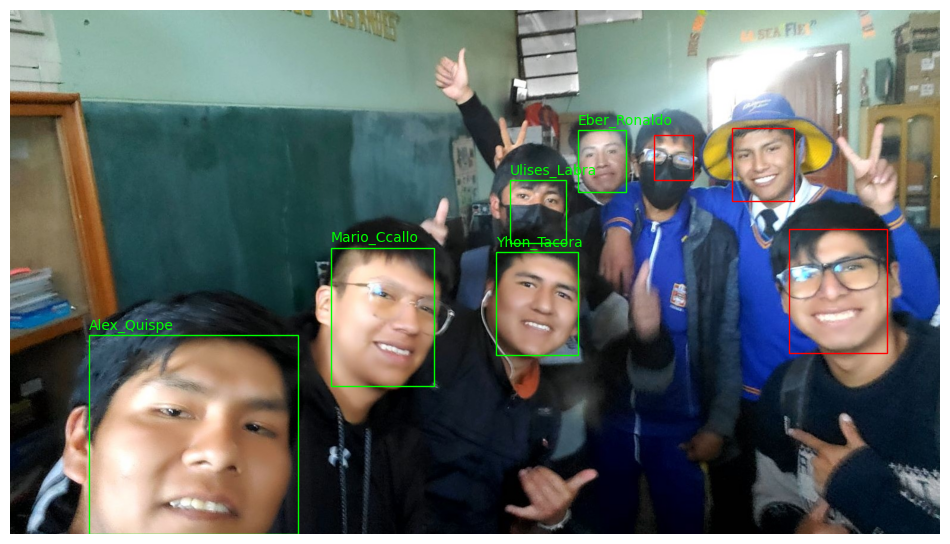

In [132]:
# Reconocimiento en imágenes
# ==============================================================================
# Detectar si se dispone de GPU cuda
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(F'Running on device: {device}')

# Identificar las personas en la imagen
fig, ax = plt.subplots(figsize=(12, 7))
imagen = Image.open('images/imagen_3.jpg')
imagen = imagen.convert('RGB')

pipeline_deteccion_imagen(
    imagen = imagen,
    dic_referencia        = dic_referencias,
    min_face_size         = 20,
    thresholds            = [0.6, 0.7, 0.7],
    min_confidence        = 0.5,
    threshold_similaridad = 0.6,
    device                = device,
    ax                    = ax,
    verbose               = False
)

In [136]:
# Video
url = ('https://github.com/giangrobert/reconigtion_facial/' + 'raw/master/video/video.mp4')
urlretrieve(url=url, filename='video/video.mp4')

('video/video.mp4', <http.client.HTTPMessage at 0x7bc58d64f1f0>)

In [137]:
# Reconocimiento en vídeo #

pipeline_deteccion_video(
    path_input_video      = '/content/video/video.mp4',
    path_output_video     = '/content/video_processed.mp4',
    dic_referencia        = dic_referencias,
    threshold_similaridad = 0.4,
)

100%|██████████| 322/322 [10:47<00:00,  2.01s/it]


In [ ]:
#https://cienciadedatos.net/documentos/py34-reconocimiento-facial-deeplearning-python

In [ ]:
# pipeline_deteccion_webcam(
#     dic_referencia        = dic_referencias,
#     threshold_similaridad = 0.4,
# )